In [234]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute._iterative import IterativeImputer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from sklearn.impute import SimpleImputer as Imputer, SimpleImputer
from sklearn.neighbors import NearestNeighbors as neigh
from sklearn.neighbors import KNeighborsRegressor as neigh
from sklearn.model_selection import train_test_split as split
from sklearn import metrics
from math import sqrt
import json
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from missingpy import KNNImputer, MissForest
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
import copy
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

Odstranenie nepotrebnych stlpcov a nacitanie.
Ziskanie kategorickych dat a pretransformovanie ich pomocou OneHotEncoder-u.
Odstranenie povodnych stlpcov a pridanie novo vytvorenych.

In [235]:
merged_data = pd.read_csv('trained_datas.csv',index_col=0)
# merged_data.info()
merged_data = merged_data.drop(['name', 'address', 'date_of_birth'], axis = 1)
categoric = merged_data.select_dtypes(include = ['object'])

encoder = ce.OneHotEncoder()
encoder.fit(categoric)
transformed = encoder.transform(categoric)

merged_data = merged_data.drop(categoric, axis = 1)
merged_data = merged_data.merge(transformed, left_index=True, right_index=True)
merged_data

,education-num,capital-gain,fnlwgt,hours-per-week,capital-loss,kurtosis_glucose,kurtosis_oxygen,mean_glucose,mean_oxygen,skewness_glucose,...,native-country_37,native-country_38,native-country_39,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7
0,1.595991,-0.307122,1.389201,2.451871,-0.227166,1.280503,3.513019,95.351562,14.103679,3.351277,...,0,0,0,1,0,0,0,0,0,0
1,-0.060364,-0.307122,0.215817,1.190629,-0.227166,0.267679,8.402489,111.164062,2.902174,-0.141940,...,0,0,0,0,1,0,0,0,0,0
2,-0.060364,-0.307122,0.276511,0.774575,-0.227166,5.600391,1.042517,14.460938,57.382107,34.223119,...,0,0,0,0,1,0,0,0,0,0
3,-0.060364,-0.307122,-0.437769,-2.727384,-0.227166,0.510415,10.508914,107.796875,1.910535,1.672603,...,0,0,0,0,1,0,0,0,0,0
4,-0.060364,-0.307122,0.055624,2.451871,-0.227166,0.459786,12.595281,111.484375,1.599498,-0.116594,...,0,0,0,0,1,0,0,0,0,0
5,-0.447286,-0.307122,-1.124758,-0.049760,-0.227166,0.981032,5.359597,91.835938,6.798495,2.209713,...,0,0,0,0,1,0,0,0,0,0
6,-0.447286,-0.307122,0.389313,-0.049760,-0.227166,0.167162,8.173738,112.007812,2.843645,-0.447539,...,0,0,0,0,1,0,0,0,0,0
7,-0.447286,-0.307122,-0.858760,-0.049760,-0.227166,2.102055,5.255796,65.539062,6.836120,9.023275,...,0,0,0,0,1,0,0,0,0,0
8,-0.447286,-0.307122,0.734508,-0.861700,-0.227166,5.325043,0.969790,22.312500,66.960702,30.008196,...,0,0,0,0,1,0,0,0,0,0
9,-0.447286,-0.307122,1.178920,-0.049760,-0.227166,0.269218,16.834602,110.406250,1.040134,0.210545,...,0,0,0,0,1,0,0,0,0,0


Vytvorenie rozhodovacieho stromu a natrenovanie ho. 

In [236]:
cls = DecisionTreeClassifier(criterion = 'entropy')

X = merged_data[merged_data.columns.difference(['class'])]
y = merged_data['class']
cls = cls.fit(X, y)


Vizualizacia rozhodovacieho stromu.

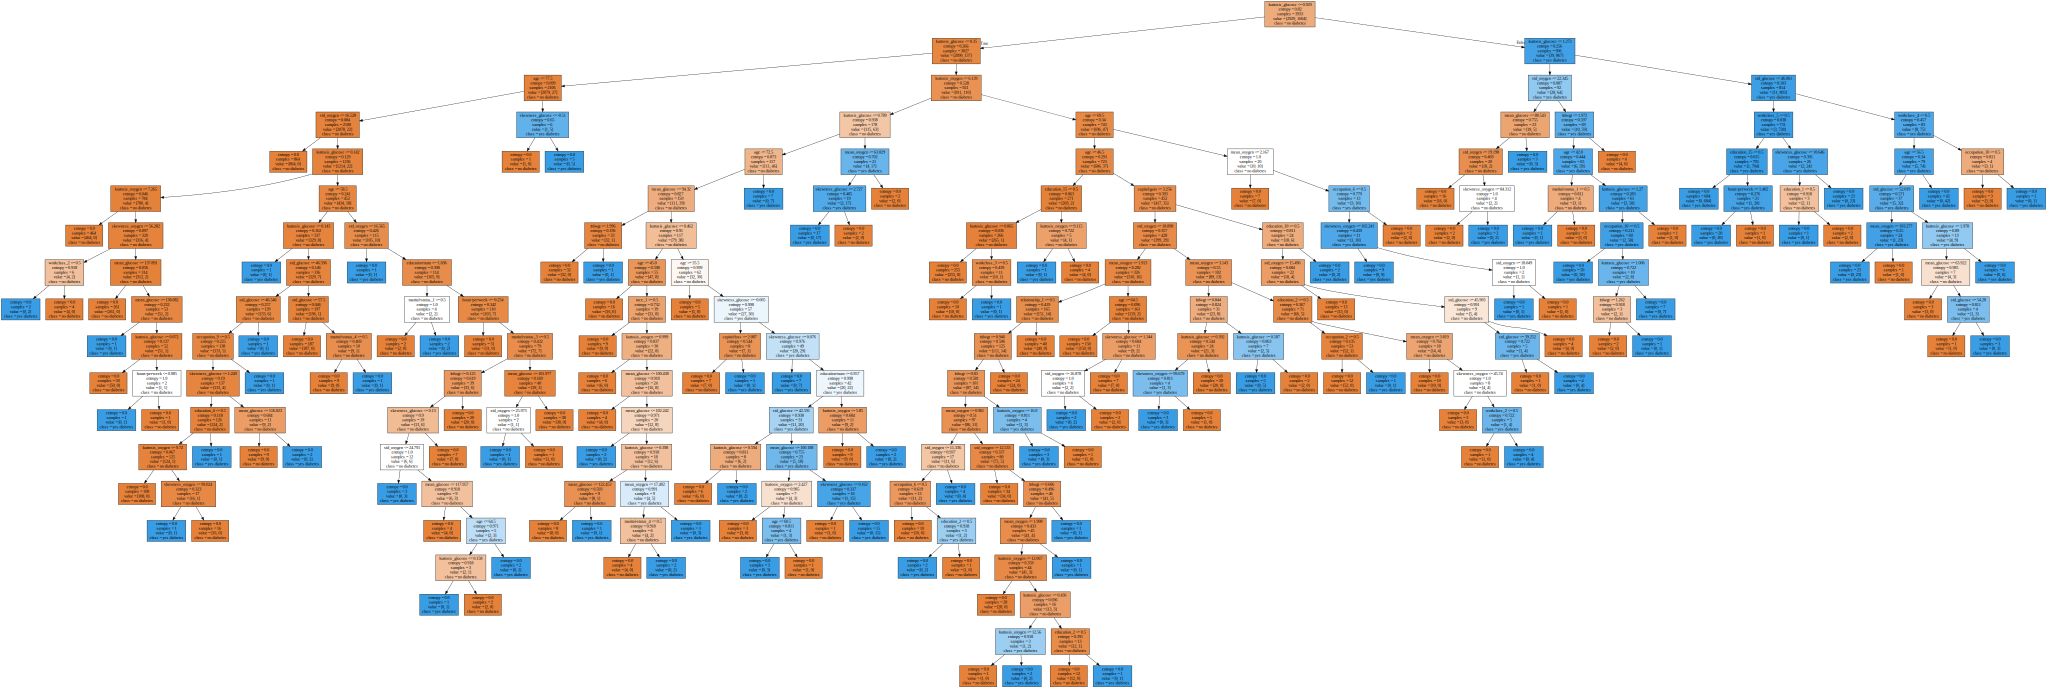

In [237]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=X.columns,
                               class_names=['no diabetes', 'yes diabetes'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

Upravenie validacnych dat priprava na pouztie v strome, pouzitie encoderu a transformovanie.

In [238]:
val_merged_data = pd.read_csv('validate_datas.csv',index_col=0)
# val_merged_data.info()
val_merged_data = val_merged_data.drop(['name', 'address', 'date_of_birth'], axis = 1)
categoric = val_merged_data.select_dtypes(include = ['object'])
transformed = encoder.transform(categoric)

val_merged_data = val_merged_data.drop(categoric, axis = 1)
val_merged_data = val_merged_data.merge(transformed, left_index=True, right_index=True)

Zistili sme, ze validacne data obsahuju v stlpci 'class' dve hodnoty NaN. Zaznamy obsahujuce tieto
hodnoty sme sa rozhodli odtranit z datasetu.

In [239]:
val_merged_data = val_merged_data.dropna()
val_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1310
Columns: 117 entries, education-num to workclass_7
dtypes: float64(15), int64(102)
memory usage: 1.2 MB


Prezenieme vsetky validacne data stromov a skontrolujeme aku presnost sme dosiahli. 
Ulozime si predikciu a nasledne ju budeme kontrolovat s povodnymi hodnotami stlpca 'class'.

In [241]:
prediction = cls.predict(val_merged_data[val_merged_data.columns.difference(['class'])])

In [242]:
print(classification_report(val_merged_data['class'],prediction, digits=3))

              precision    recall  f1-score   support

         0.0      0.971     0.942     0.956       963
         1.0      0.851     0.922     0.885       346

    accuracy                          0.937      1309
   macro avg      0.911     0.932     0.921      1309
weighted avg      0.939     0.937     0.937      1309

